## Part 1

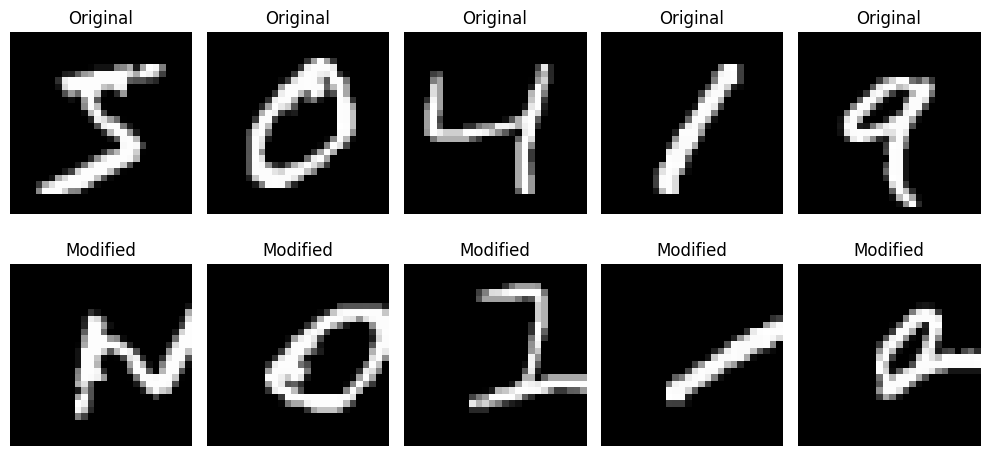

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from scipy.ndimage import rotate, shift

# Load MNIST dataset
(x_train_orig, y_train), (x_test_orig, y_test) = mnist.load_data() # (image, label)

def modify_image(image):
    # Reflect the image horizontally
    reflected_image = np.fliplr(image)

    # Rotate the image by 90 degrees
    rotated_image = rotate(reflected_image, angle=90, reshape=False, order=1)

    # Translate the image to the right by 5 pixels
    translated_image = shift(rotated_image, shift=[0, 5], mode='constant', cval=0)

    return translated_image

# Modify the train and test datasets
x_train = np.array([modify_image(img) for img in x_train_orig])
x_test = np.array([modify_image(img) for img in x_test_orig])

# Verify a few transformed images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_orig[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(x_train[i], cmap='gray')
    plt.title("Modified")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the modified dataset
np.savez('modified_mnist.npz',
         train_images=x_train,
         train_labels=y_train,
         test_images=x_test,
         test_labels=y_test)

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Convert grayscale to RGB and resize
def preprocess_data(x, y, num_samples):
    indices = []
    for label in range(10):  # Select 'num_samples' images per class
        indices.extend(np.where(y == label)[0][:num_samples])
    x_subset, y_subset = x[indices], y[indices]

    # Convert grayscale to RGB and resize
    x_subset = tf.image.grayscale_to_rgb(tf.expand_dims(x_subset, axis=-1))
    x_subset = tf.image.resize(x_subset, [224, 224]) # Resize to match 224x224
    x_subset = x_subset / 255.0 # Normalize pixel values
    x_subset = x_subset.numpy()
    y_subset = to_categorical(y_subset, 10)
    return x_subset, y_subset

# Function to fine-tune and evaluate
def fine_tune_resnet(x_train, y_train, x_test, y_test, num_samples, batch_size, learning_rate, max_epoch, patience):
    x_subset, y_subset = preprocess_data(x_train, y_train, num_samples)
    x_test, y_test = preprocess_data(x_test, y_test, num_samples)
    x_train_sub, x_val_sub, y_train_sub, y_val_sub = train_test_split(x_subset, y_subset, test_size=0.2)

    # Load ResNet50 and fine-tune
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers of ResNet50 (feature extraction layers)
    for layer in base_model.layers:
        layer.trainable = False

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax', kernel_initializer='he_normal', bias_initializer='zeros') # Output layer with 10 neurons & initialize randomly weights and biases
    ])

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])

    # Training with early stopping
    best_test_accuracy = 0
    # best_epoch = 0
    patience_counter = 0


    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    
    for epoch in range(max_epoch):
        history = model.fit(x_train_sub, y_train_sub, validation_data=(x_val_sub, y_val_sub),
                            batch_size=batch_size, epochs=1, verbose=0)

        train_losses.append(history.history['loss'][0])
        train_accuracies.append(history.history['accuracy'][0])

        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Only print every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}: Train Error = {history.history['loss'][0]:.4f}, Train Accuracy = {history.history['accuracy'][0] * 100:.2f}%, Test Error = {test_loss:.4f}, Test Accuracy = {test_accuracy * 100:.2f}%")

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            patience_counter = 0
        else:
            patience_counter += 1 

        # Stop early if no improvement
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch + 1}: Train Error = {history.history['loss'][0]:.4f}, Train Accuracy = {history.history['accuracy'][0] * 100:.2f}%, Test Error = {test_loss:.4f}, Test Accuracy = {test_accuracy * 100:.2f}%")
            break
    
    return epoch + 1, train_accuracies, train_losses, test_accuracies, test_losses, model

In [8]:
# Hyperparameters
num_samples = [1, 5, 10, 50, 100]
batch_size = 32
learning_rate = 0.01
max_epoch = 100
patience = 10  # Stop if accuracy keep increasing for 10 epochs


stopping_epochs = []
best_train_accuracies = []
best_train_losses = []
best_test_accuracies = []
best_test_losses = []

for n in num_samples:
    print(f"\nTrain size {n*10}")
    best_epoch, train_acc, train_loss, test_acc, test_loss, model = fine_tune_resnet(x_train, y_train, x_test, y_test, n, batch_size, learning_rate, max_epoch, patience)
    stopping_epochs.append(best_epoch)
    best_train_accuracies.append(train_acc[-1])
    best_train_losses.append(train_loss[-1])
    best_test_accuracies.append(test_acc[-1])
    best_test_losses.append(test_loss[-1])


Train size 10
Epoch 5: Train Error = 2.2342, Train Accuracy = 12.50%, Test Error = 3.9339, Test Accuracy = 20.00%
Epoch 10: Train Error = 1.9604, Train Accuracy = 25.00%, Test Error = 4.4722, Test Accuracy = 0.00%
Epoch 15: Train Error = 1.7124, Train Accuracy = 37.50%, Test Error = 4.7952, Test Accuracy = 20.00%
Stopping early at epoch 15: Train Error = 1.7124, Train Accuracy = 37.50%, Test Error = 4.7952, Test Accuracy = 20.00%

Train size 50
Epoch 5: Train Error = 2.6328, Train Accuracy = 12.50%, Test Error = 2.3712, Test Accuracy = 12.00%
Epoch 10: Train Error = 2.2023, Train Accuracy = 27.50%, Test Error = 2.2627, Test Accuracy = 12.00%
Epoch 15: Train Error = 2.2233, Train Accuracy = 20.00%, Test Error = 2.1770, Test Accuracy = 22.00%
Epoch 20: Train Error = 1.8915, Train Accuracy = 27.50%, Test Error = 1.9311, Test Accuracy = 44.00%
Epoch 25: Train Error = 1.6749, Train Accuracy = 47.50%, Test Error = 1.8312, Test Accuracy = 42.00%
Epoch 30: Train Error = 1.5794, Train Accuracy

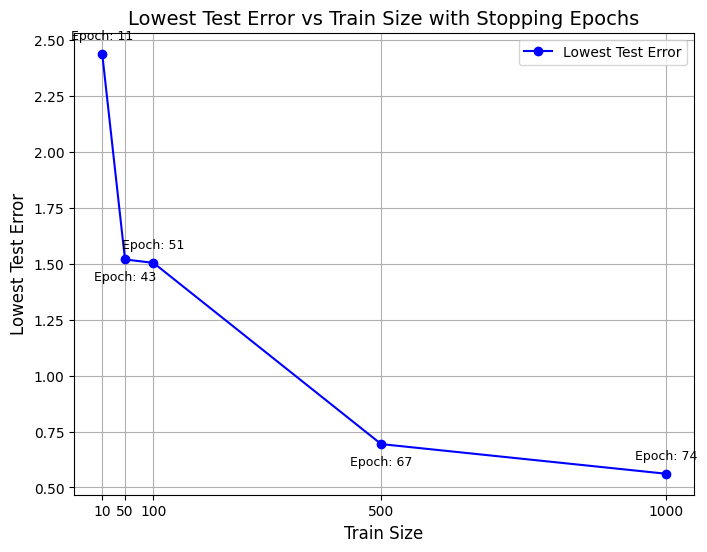

In [9]:
import matplotlib.pyplot as plt

# Data
train_sizes = [10, 50, 100, 500, 1000]
lowest_test_errors = [2.4399, 1.5197, 1.5045, 0.6939, 0.5614]
stopping_epochs = [11, 43, 51, 67, 74]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, lowest_test_errors, marker='o', linestyle='-', color='b', label='Lowest Test Error')

# Annotate the stopping epochs with alternating offsets
for i, (x, y, epoch) in enumerate(zip(train_sizes, lowest_test_errors, stopping_epochs)):
    offset = 0.05 if i % 2 == 0 else -0.05  # Alternate offsets
    plt.text(x, y + offset, f'Epoch: {epoch}', fontsize=9, ha='center', va='bottom' if offset > 0 else 'top')

# Add labels, title, and legend
plt.xlabel('Train Size', fontsize=12)
plt.ylabel('Lowest Test Error', fontsize=12)
plt.title('Lowest Test Error vs Train Size with Stopping Epochs', fontsize=14)
plt.xticks(train_sizes)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [10]:
# Save the model for HW4
model.save('mnist_resnet50_model_hw3_part1.h5')

Part 1. 2 
Use MNIST and FashionMNIST

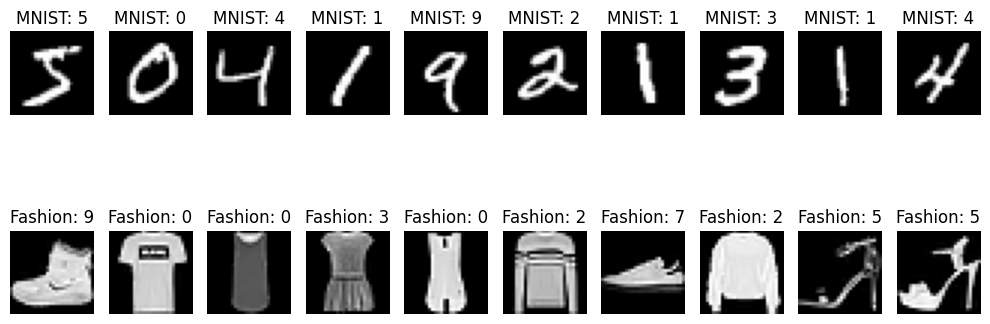

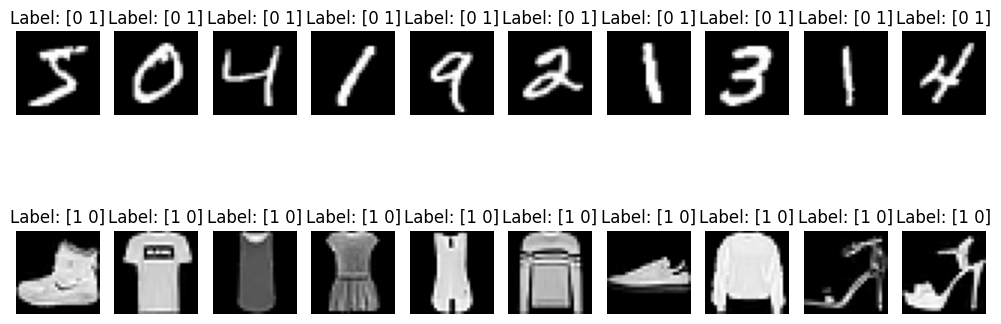

2025-02-26 13:42:48.731630: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-02-26 13:42:48.731656: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-26 13:42:48.731659: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1740606168.731902 5192177 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740606168.731960 5192177 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-02-26 13:42:50.913844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.5000 - loss: 1.1493
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5312 - loss: 1.3895
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5000 - loss: 0.7023
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5469 - loss: 0.9173
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5562 - loss: 0.6984
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5250 - loss: 0.8189
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6687 - loss: 0.5136
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6375 - loss: 0.5240
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6656 - loss: 0.5301
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7594 - loss: 0.4198
Train Loss: 0.4822, Train Accuracy: 70.00%
Test Loss: 0.5522, Test Accuracy: 62.83%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Load MNIST and FashionMNIST datasets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Select 10 images from each dataset
x_train_mnist, y_train_mnist = x_train_mnist[:10], y_train_mnist[:10]
x_train_fashion, y_train_fashion = x_train_fashion[:10], y_train_fashion[:10]


# Visualize the selected images from MNIST
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train_mnist[i], cmap='gray')
    plt.title(f"MNIST: {y_train_mnist[i]}")
    plt.axis('off')

# Visualize the selected images from FashionMNIST
for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_fashion[i], cmap='gray')
    plt.title(f"Fashion: {y_train_fashion[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Create labels for MNIST as [0, 1]
y_train_mnist = np.array([[0, 1]] * len(y_train_mnist))

# Create labels for FashionMNIST as [1, 0]
y_train_fashion = np.array([[1, 0]] * len(y_train_fashion))

# Combine MNIST and FashionMNIST images and labels
x_train_combined = np.concatenate((x_train_mnist, x_train_fashion), axis=0)
y_train_combined = np.concatenate((y_train_mnist, y_train_fashion), axis=0)

import matplotlib.pyplot as plt

# Visualize the combined images with their labels
plt.figure(figsize=(10, 5))
for i in range(len(x_train_combined)):
    plt.subplot(2, len(x_train_combined) // 2, i + 1)
    plt.imshow(x_train_combined[i], cmap='gray')  # Convert tensor to NumPy array for visualization
    plt.title(f"Label: {y_train_combined[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Preprocess the images (resize to 224x224 and convert to RGB)
def preprocess_data(x):
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)  # Add channel dimension
    x = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x))  # Convert grayscale to RGB
    x = tf.image.resize(x, [224, 224])  # Resize to 224x224
    return x 

x_train_combined = preprocess_data(x_train_combined)

# Load ResNet50 model and replace the output layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Build a new model with the modified output layer
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax', kernel_initializer='he_normal', bias_initializer='zeros')  # Output layer with 2 neurons for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


# Train the model using only 20 images (10 from MNIST, 10 from FashionMNIST)
model.fit(x_train_combined, y_train_combined, epochs=10, batch_size=8, verbose=1)

# Evaluate on training data
train_loss, train_accuracy = model.evaluate(x_train_combined, y_train_combined, verbose=0)

# One-hot encode the test labels for MNIST and FashionMNIST
y_test_mnist = np.array([[0, 1]] * len(y_test_mnist))  # MNIST labels as [0, 1]
y_test_fashion = np.array([[1, 0]] * len(y_test_fashion))  # FashionMNIST labels as [1, 0]

# Combine MNIST and FashionMNIST test images and labels
test_images = np.concatenate((x_test_mnist, x_test_fashion), axis=0)
test_labels = np.concatenate((y_test_mnist, y_test_fashion), axis=0)

# Preprocess the test images
test_images = preprocess_data(test_images)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)

# Print evaluation metrics
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

In [4]:
# Save the model for HW4
model.save('mnist_resnet50_model.h5')